In [1]:
import pandas as pd
import numpy as np

In [253]:
import json

In [22]:
import math
import os
from datetime import datetime,timedelta
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

In [52]:
data = pd.read_csv("../data/processed/period/ecmen/6_16/ecmenperiod1.csv.gz",compression='gzip',parse_dates=["Trade_Datetime","ecmen_public_time"],index_col=["Trade_Datetime"])

In [56]:
weather_data = pd.read_csv("../data/processed/WeatherData/ecmen_weather_subclass.csv", parse_dates=["Trans_INIT_Time"])

In [57]:
weather_data

,Trans_INIT_Time,VALUE_hdd,10Y_NORMAL_hdd,Sum_Value_hdd,Delta_Full_hdd,Delta_Sub_hdd,VALUE_cdd,10Y_NORMAL_cdd,Sum_Value_cdd,Delta_Full_cdd,Delta_Sub_cdd
0,2015-01-01 01:40:00,34.32,28.51,451.82,0.00,0.00,0.19,0.19,2.70,0.00,0.00
1,2015-01-01 13:40:00,31.67,28.67,444.46,-2.95,-7.40,0.33,0.17,2.55,-0.09,0.02
2,2015-01-02 01:40:00,30.88,28.67,453.45,8.99,10.39,0.31,0.17,2.67,0.12,0.04
3,2015-01-02 13:40:00,27.33,28.70,448.02,-4.52,-4.38,0.49,0.16,2.59,0.10,0.11
4,2015-01-03 01:40:00,27.17,28.70,462.12,14.10,7.93,0.47,0.16,2.42,-0.17,-0.19
...,...,...,...,...,...,...,...,...,...,...,...
4559,2021-03-29 14:40:00,13.28,15.52,183.28,-1.00,-0.30,1.03,0.98,11.18,0.85,0.36
4560,2021-03-30 02:40:00,12.96,15.52,182.09,-1.19,-0.23,1.05,0.98,10.79,-0.39,-0.37
4561,2021-03-30 14:40:00,16.46,15.32,187.37,6.19,4.68,0.93,1.01,11.53,0.37,-0.26
4562,2021-03-31 02:40:00,16.35,15.32,187.16,-0.21,-0.95,0.87,1.01,11.76,0.23,-0.43


In [59]:
data["Trade_time"] = data.index.time

In [63]:
res = data.groupby(['Contract_Delivery_Date', pd.Grouper(freq='D')]).agg(Normal_Vwap=('Normal_Vwap', list),Trade_time=('Trade_time',list) ,ecmen_public_time=('ecmen_public_time', 'first'),dst_flag=('dst_flag', 'first'))

In [67]:
merge_data = pd.merge(res, weather_data, how="left",left_on='ecmen_public_time', right_on='Trans_INIT_Time',
                      suffixes=('_hdd', '_cdd'))

In [70]:
merge_data.shape

(1620, 15)

In [363]:
def dba_fit_predict_data(n_cluster, period_data, data_name, save_model_path=None):
    seed = 13
    dba_km = TimeSeriesKMeans(n_clusters=n_cluster,
                              metric="dtw",
                              n_jobs=8,
                              max_iter_barycenter=10,
                              verbose=False,
                              n_init=2,
                              random_state=seed)
    y_pred = dba_km.fit_predict(period_data)
    if save_model_path:
        os.makedirs(save_model_path, exist_ok=True)
        file_name = "dba_"+data_name+"_"+str(n_cluster)
        dba_km.to_pickle(os.path.join(save_model_path, file_name+".pkl"))
    return dba_km, y_pred

In [23]:
period_data = to_time_series_dataset(res["Normal_Vwap"].values)

In [364]:
dba_km, y_pred = dba_fit_predict_data(n_cluster=16,
                              period_data=period_data,
                              data_name="gfsenperiod1",
                              save_model_path="")

In [72]:
merge_data["label"] = y_pred
merge_data["Month"] = merge_data["Trans_INIT_Time"].dt.month

In [376]:
def show_time_series(period_df, label, dba_km, axs_fig):
    max_index = []
    for Normal_Vwap, Trade_time, dst_flag in period_df[period_df["label"] == label][["Normal_Vwap", "Trade_time", "dst_flag"]].values:
        color = [0.7, 0.8, 0.8]
        if dst_flag == 1:
            color = [1, 0.96, 0.56]
        Trade_time = normalize_time(Trade_time)
        if len(Trade_time) > len(max_index):
            max_index = Trade_time
        sns.lineplot(x=Trade_time, y=Normal_Vwap, color=color, ax=axs_fig)
    center_df = pd.DataFrame(
        {"Time": max_index, "normal_vwap": dba_km.cluster_centers_[label].ravel()})
    sns.lineplot(x="Time", y="normal_vwap", data=center_df,
                 color="red", ax=axs_fig)

In [360]:
def show_cluster_center(max_index, dba_km, label, axs_fig):
    center_df = pd.DataFrame(
        {"index": max_index.values, "data": dba_km.cluster_centers_[label].ravel()})
    sns.lineplot(x="index", y="data", data=center_df,
                 color="red", ax=axs_fig)

In [98]:
def normalize_time(series):
    series = pd.to_datetime(series, format="%H:%M:%S").to_series()
    series += pd.to_timedelta(series.lt(series.shift()).cumsum(), unit="D")
    # print(series)
    return series.values

In [126]:
def show_clustering(n_clusters, y_pred, period_df, file_name):
    plot_count = math.ceil(math.sqrt(n_clusters))
    fig, axs = plt.subplots(n_clusters, 8, figsize=(40, 80))
    row_i = 0
    column_j = 0

    # len_max_index, max_index = get_max_index(period_df)
    for label in set(y_pred):
        #column_j = 1
        show_time_series(period_df=period_df,label=label, axs_fig=axs[row_i, column_j])

        # assert len_max_index == len(dba_km.cluster_centers_[
        #                             label].ravel()), "time max index length error!"
        # show_cluster_center(max_index, dba_km,label=label,axs_fig=axs[row_i, column_j])
        # show_ci_box(ci_df,label=label,ax_fig=axs[row_i, column_j])

        axs[row_i, column_j].set_title(
            "Cluster "+str(row_i))
        axs[row_i, column_j].xaxis.set_major_formatter(
            matplotlib.dates.DateFormatter("%H:%M")
        )
        #axs[row_i, column_j].set_xticklabels(rotation=45, ha='right')
        row_i += 1
        # if column_j % plot_count == 0:
        #     row_i += 1
        #     column_j = 0
    
    
    # plt.savefig(file_name+".png", dpi=200,
    #             bbox_inches="tight", orientation='landscape')

In [235]:
stat_feature = ['Sum_Value_hdd','Delta_Full_hdd', 'Delta_Sub_hdd', 'Sum_Value_cdd', 'Delta_Full_cdd', 'Delta_Sub_cdd']
stats = merge_data.groupby(['label'])[stat_feature].agg(['mean', 'count', 'std'])

In [293]:
ci = 0.95
ci_data = []
for label in stats.index:
    for fe in stat_feature:
        mean, count, std = stats.loc[label, fe]
        z_hat = norm.ppf(ci+(1-ci)/2)*std/math.sqrt(count)
        ci_left, ci_right = mean-z_hat, mean+z_hat
        ci_data.append({'label':label, 'feature':fe, 'ci_left':ci_left, 'ci_right':ci_right})
ci_df = pd.DataFrame(ci_data)

In [380]:
def show_ci_box(ci_df, label, ax_fig):
    query_res = []
    ci_df_index_label = ci_df.set_index(['label'])
    for feature, ci_left, ci_right in ci_df_index_label.loc[label].values:
        ci_dict = {feature:"[{:.2f}, {:.2f}]".format(ci_left, ci_right)}
        query_res.append("\n".join("{}: {}".format(*i)
                                       for i in ci_dict.items()))
    query_i = 0
    ax_fig.axis('off')
    ax_fig.set_title("Confidence Interval")
    for item in np.arange(0.05, 0.95, 0.15).tolist():
        ax_fig.text(0.1, item, query_res[query_i],
                    size=14)
        query_i += 1

In [388]:
def show_confidence_interval(df, ax):
    ci_d = df.round(2)[["ci_left", "ci_right"]]
    SE_hat_x_list = list(ci_d.itertuples(index=False, name=None))
    x_hat_list = [(x[0]+x[1])/2 for x in SE_hat_x_list]
    for i in range(len(x_hat_list)):
        ax.errorbar(x_hat_list[i], np.arange(len(x_hat_list))[
                    i], lolims=True, xerr=SE_hat_x_list[i][1]-x_hat_list[i], yerr=0.0, linestyle='', c='black', elinewidth=3, mew=3)

In [354]:
def show_month_dist(df, label, ax):
    label_df = df[df['label'] == label]
    sns.countplot(x="Month", data=label_df, ax=ax)
    

In [ ]:
show_clustering(16, y_pred,merge_data,"sdf")

In [110]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

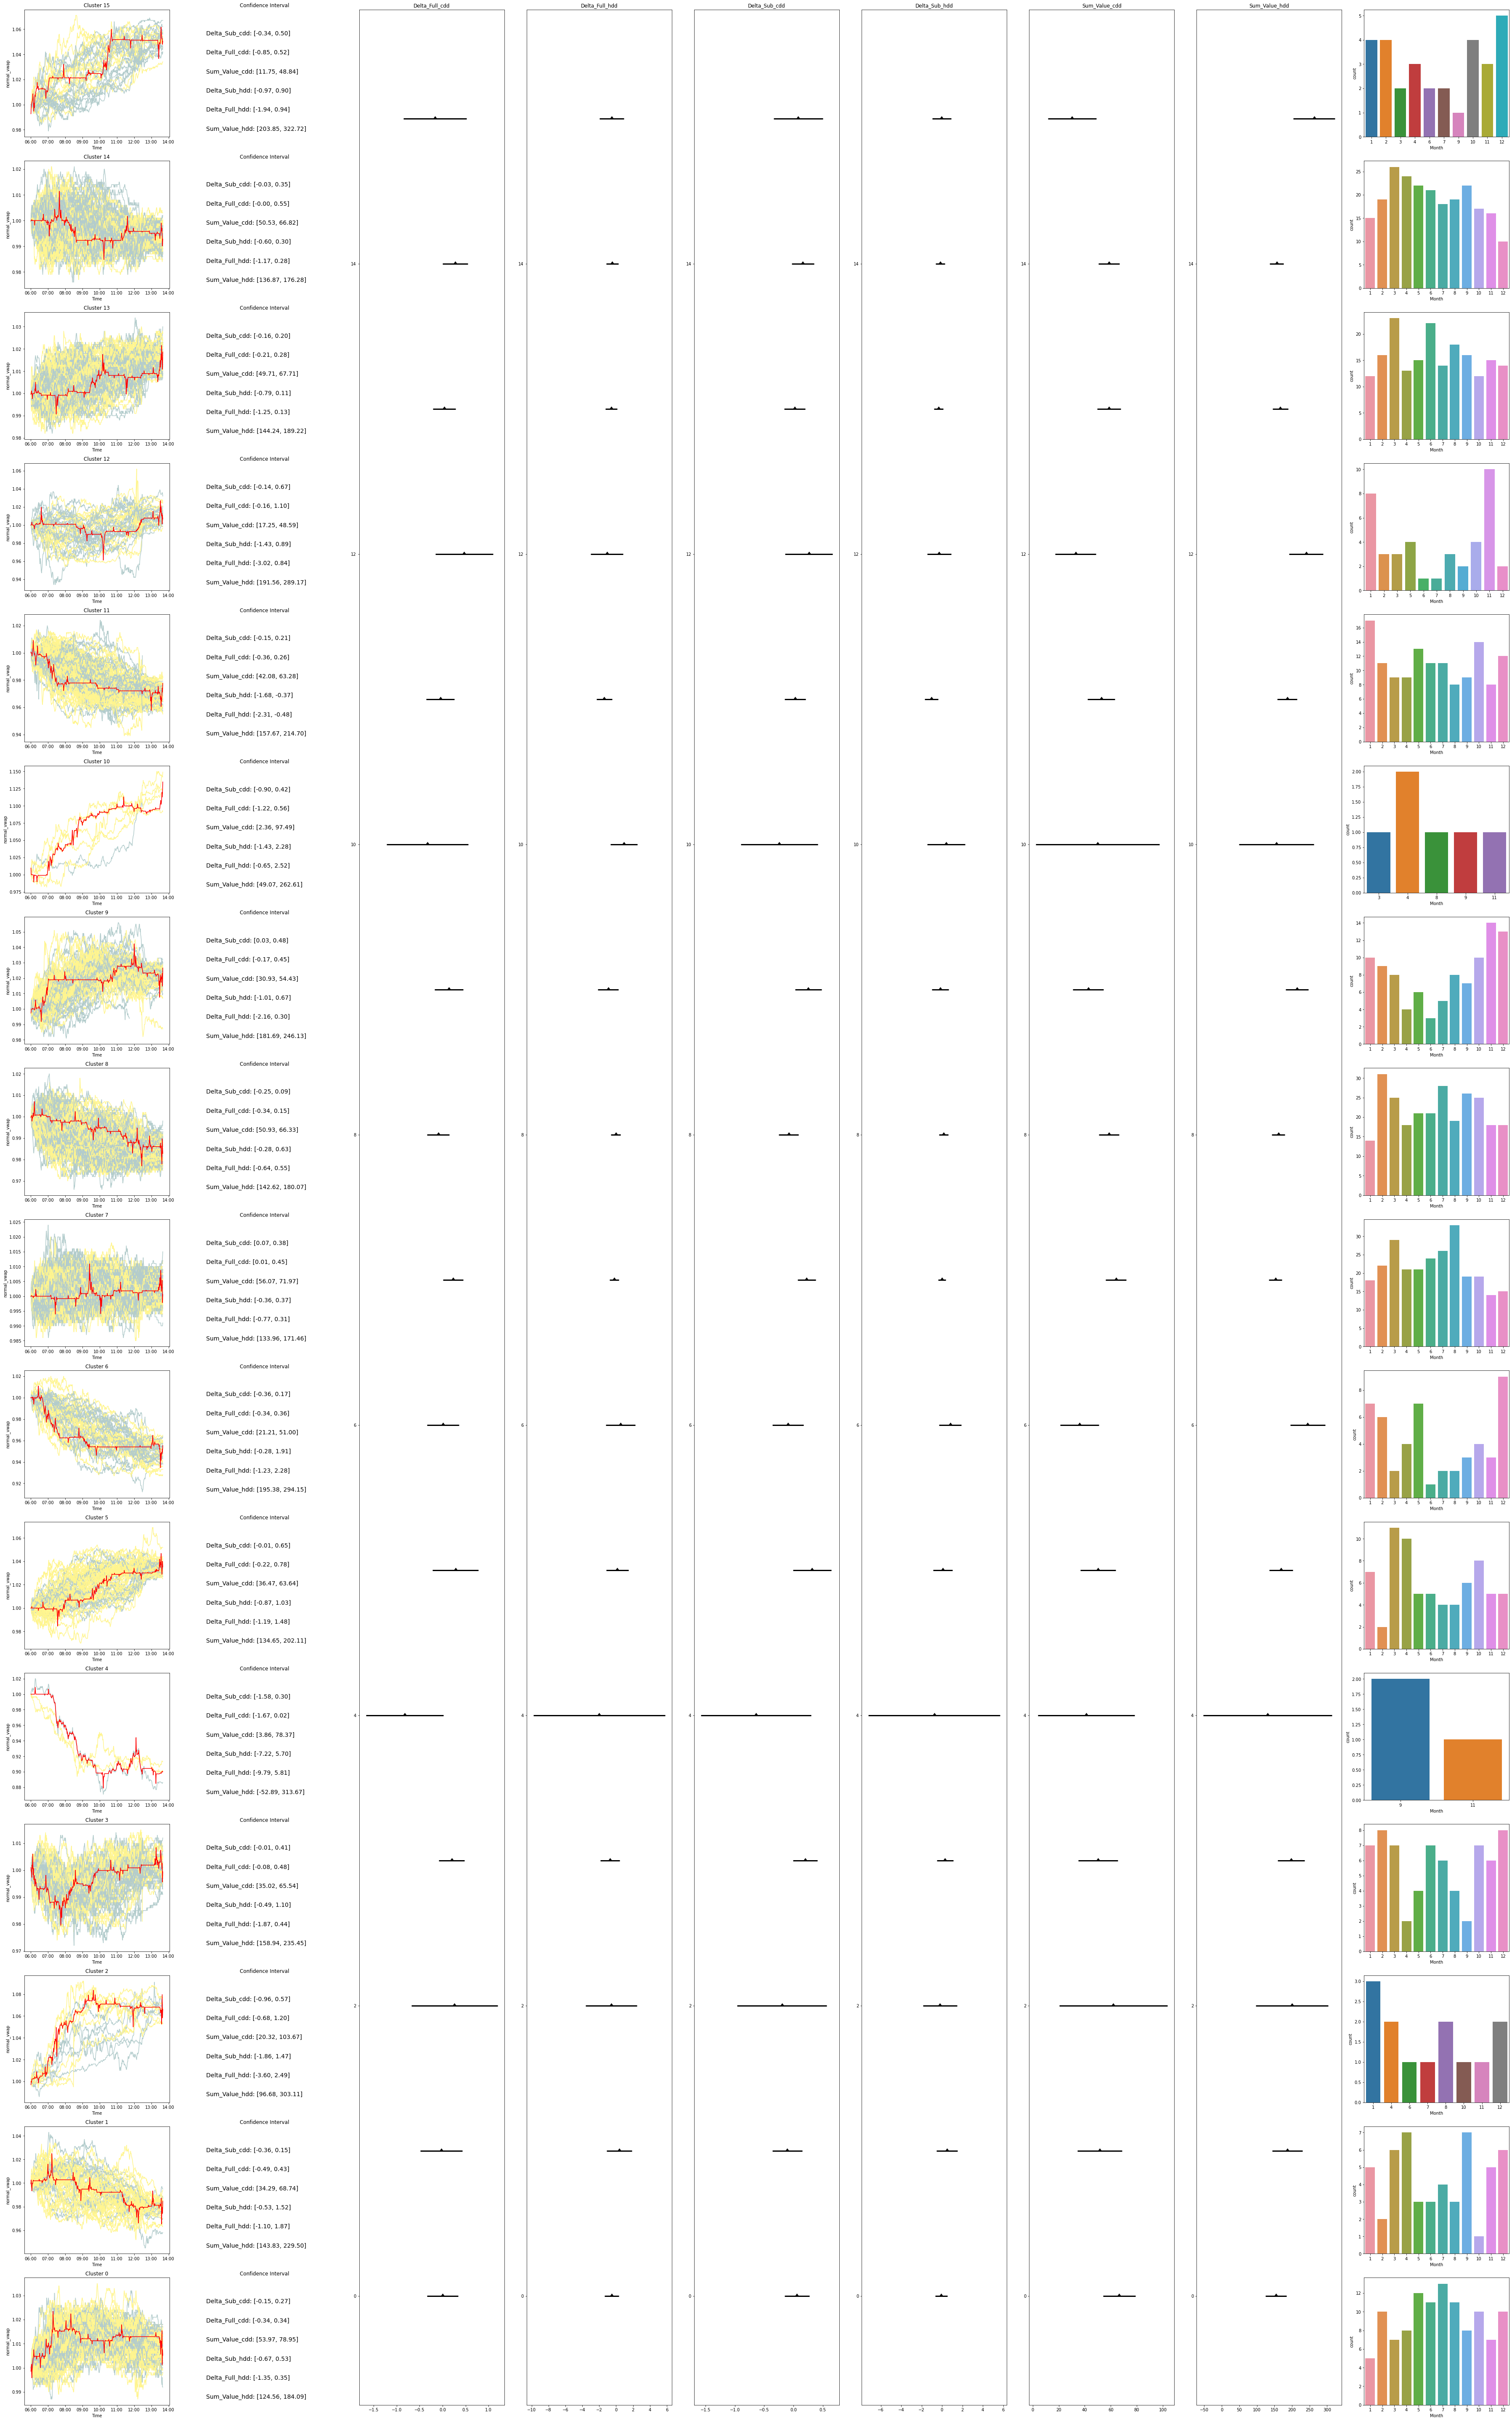

In [389]:
fig = plt.figure(figsize=(50, 80))
gs = GridSpec(16, 9, figure=fig)

row_i, column_j = 0, 0
for i, label in enumerate(reversed(range(16))):
    ax = fig.add_subplot(gs[i, 0])
    ax.set_title("Cluster "+str(label))
    ax.xaxis.set_major_formatter(
        matplotlib.dates.DateFormatter("%H:%M")
    )
    #column_j = 1
    show_time_series(period_df=merge_data,dba_km=dba_km,label=label, axs_fig=ax)
    
    ax2 = fig.add_subplot(gs[i, 1])
    show_ci_box(ci_df, label, ax2)
    
    ax3 = fig.add_subplot(gs[i, -1])
    show_month_dist(merge_data, label=label, ax=ax3)
i = 2
for feature, d in ci_df.groupby("feature"):
    ax = fig.add_subplot(gs[:, i])
    show_confidence_interval(d, ax)
    ax.set_title(feature)
    i += 1
# ax1 = fig.add_subplot(gs[1, 1])
# show_time_series(period_df=merge_data,label=0,axs_fig=ax1)
# # # identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
# # ax2 = fig.add_subplot(gs[1, :-1])
# # ax3 = fig.add_subplot(gs[1:, -1])
# # ax4 = fig.add_subplot(gs[-1, 0])
# # ax5 = fig.add_subplot(gs[-1, -2])

#fig.suptitle("Ecmen_period1")
# # format_axes(fig)
fig.tight_layout(pad=1.0)
plt.savefig("Ecmen_period1.pdf", bbox_inches="tight", orientation='landscape')